In [1]:
# imports and setup
import math
import numpy as np
from scipy.stats import norm, invgamma
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [36]:
class BayesProblem:
    def __init__(self, prior_dist, likelihood_dist, likelihood_space_dim, num_of_buckets, strategy="equal_interval"):
      self.num_of_buckets = num_of_buckets
      self.num_of_prior = len(prior_dist)
      self.strategy = strategy

      # Prior
      self.prior_dist = prior_dist
      self.prior_buckets = self.create_buckets([self.prior_dist],
                                               self.num_of_buckets,
                                               self.strategy,
                                               include_mid_point=True)
      self.prior_prob = self.discrete_probability(self.prior_dist, self.prior_buckets)

      # Likelihood
      self.likelihood_dist = likelihood_dist
      self.likelihood_prob = self.likelihood_probability(*likelihood_space_dim)

      # Posterior
      self.posterior_prob = self.posterior_probability()

    def dist_stats(self, dist):
      dist_mean = []
      dist_std = []

      for i in range(len(dist)):
        m, v = dist[i].stats(moments='mv')
        dist_mean.append(m)
        std = math.sqrt(v)
        dist_std.append(std)

      return (dist_mean, dist_std)

    def start_end_dist(self, mu, std):
      start_dist = []
      end_dist = []

      for i in range(len(mu)):
        start_dist.append(mu[i] - 3*std[i])
        end_dist.append(mu[i] + 3*std[i])

      return [start_dist, end_dist]

    def multiply_lists(self, *args):
      if len(args) == 0:
        return []

      if len(args) == 1:
        return args[0]

      current_list = args[0]
      remaining_lists = args[1:]

      temp = []
      for item1 in current_list:
        sub_result = multiply_lists(*remaining_lists)
        for item2 in sub_result:
          temp.append(item1 * item2)

      return temp

    def equal_interval(self, start_b, end_b, number_of_buckets, include_mid_point=False):
      buckets = []

      for i in range(len(start_b)):
        bp = np.linspace(start_b[i], end_b[i], number_of_buckets + 1)
        bkt = []

        for j in range(len(bp) - 1):
          if include_mid_point:
            midpoint = (bp[j] + bp[j + 1]) / 2
            bkt.append((bp[j], bp[j + 1], midpoint))
          else:
            bkt.append((bp[j], bp[j + 1]))

        buckets.append(bkt)

      return buckets

    def create_buckets(self, args, number_of_buckets, strategy="equal_interval", include_mid_point=False):
      buckets = []

      if strategy == "equal_interval" and len(args) == 2:
        buckets = self.equal_interval([args[0]], [args[1]], number_of_buckets, include_mid_point)

      elif strategy == "equal_interval" and len(args) == 1:
        m, s = self.dist_stats(args[0])
        start_end = self.start_end_dist(m, s)
        buckets = self.equal_interval(start_end[0], start_end[1], number_of_buckets, include_mid_point)

      return buckets

    def bucket_probability(self, dist, start, end):
      return dist.cdf(end) - dist.cdf(start)

    def discrete_probability(self, dist, buckets):
      disc_prob = []
      prob_dim = []
      dist_prob = []

      for i in range(len(dist)):
        temp_prob = []
        prob_dim.append(len(buckets[i]))
        for b in buckets[i]:
          prob = self.bucket_probability(dist[i], b[0], b[1])
          temp_prob.append(prob)

        dist_prob.append(temp_prob)

      disc_prob = np.array(self.multiply_lists(*dist_prob)).reshape(prob_dim)

      return disc_prob


    def likelihood_probability(self, start_obs, end_obs):
      self.likelihood_buckets = self.create_buckets([start_obs, end_obs],
                                                    self.num_of_buckets * 2)
      likelihood_matrix = []

      # index 0 because trying for one distribution
      for i, prior_b in enumerate(self.prior_buckets[0]):
        prob_i = self.prior_prob[i]
        likelihood_i = []

        # index 0 because trying for one distribution
        for obs_b in self.likelihood_buckets[0]:
          prob_ij, _ = integrate.quad(lambda mu: self.bucket_probability(self.likelihood_dist(mu),
                                                                         obs_b[0],
                                                                         obs_b[1]) * prob_i,
                                      prior_b[0], prior_b[1])
          likelihood_i.append(prob_ij)

        likelihood_matrix.append(likelihood_i)

      likelihood_matrix = np.asarray(likelihood_matrix)
      return likelihood_matrix

    def posterior_probability(self):
      evidence_prob = np.sum(self.likelihood_prob, axis=0)

      posterior_prob = []

      for i in range(len(self.prior_prob)):
        temp = []

        for j in range(len(evidence_prob)):
          temp.append(self.likelihood_prob[i,j] / evidence_prob[j])

        posterior_prob.append(temp)

      posterior_prob = np.asarray(posterior_prob).T
      return posterior_prob


    def calculate_posterior(self, x):
      for i in range(len(self.likelihood_buckets[0])):
        b_i, b_j = self.likelihood_buckets[0][i]
        if x >= b_i and x < b_j:
          return self.posterior_prob[i]

In [37]:
# Example usage
prior_mean = 3
prior_std = 1
num_of_buckets = 6
likelihood_std = 0.5

likelihood_space = lambda mu: norm(mu, likelihood_std)
prior_space = norm(prior_mean, prior_std)

def likelihood_dist(mu):
    return norm(mu, likelihood_std)

start_obs = prior_mean - 3 * prior_std - 3 * likelihood_std
end_obs = prior_mean + 3 * prior_std + 3 * likelihood_std

obj = BayesProblem([prior_space], likelihood_dist, [start_obs, end_obs], num_of_buckets)

In [38]:
obj.posterior_prob

array([[9.87307895e-01, 1.26903297e-02, 1.77568280e-06, 2.24504380e-12,
        2.34904210e-20, 1.93308746e-30],
       [8.70743191e-01, 1.28982189e-01, 2.74614629e-04, 6.01199699e-09,
        1.15589170e-15, 1.80187240e-24],
       [4.35183237e-01, 5.50086637e-01, 1.47250069e-02, 5.11942025e-06,
        1.73727141e-11, 5.02353082e-19],
       [8.37736597e-02, 7.30674898e-01, 1.84681028e-01, 8.70365531e-04,
        4.85678568e-08, 2.51842555e-14],
       [5.39932429e-03, 3.40734429e-01, 6.23123343e-01, 3.07181496e-02,
        2.47537297e-05, 2.17149295e-10],
       [9.06716268e-05, 5.40283491e-02, 6.81769334e-01, 2.61681147e-01,
        2.43017410e-03, 3.24381899e-07],
       [3.24381899e-07, 2.43017410e-03, 2.61681147e-01, 6.81769334e-01,
        5.40283491e-02, 9.06716268e-05],
       [2.17149292e-10, 2.47537297e-05, 3.07181496e-02, 6.23123343e-01,
        3.40734429e-01, 5.39932429e-03],
       [2.51873278e-14, 4.85678568e-08, 8.70365531e-04, 1.84681028e-01,
        7.30674898e-01, 

In [39]:
observed_data = norm.rvs(loc=2, scale=likelihood_std, size=10)
observed_data

array([3.18755612, 1.45621405, 2.02202744, 1.64778234, 2.14973402,
       1.75308178, 0.86954731, 3.27933319, 1.67753759, 2.14848969])

In [40]:
x = 1.9587854306724626

observed_pdf = obj.calculate_posterior(x)
observed_pdf

array([5.39932429e-03, 3.40734429e-01, 6.23123343e-01, 3.07181496e-02,
       2.47537297e-05, 2.17149295e-10])

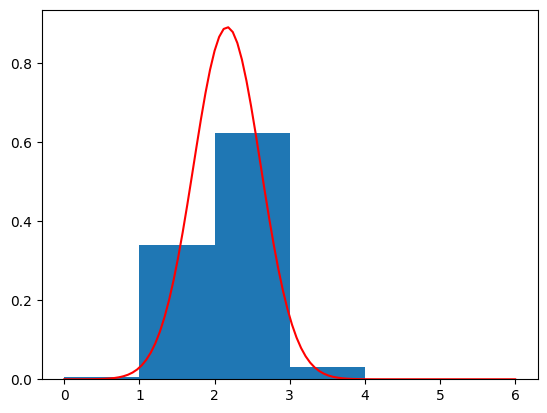

In [42]:
bar_x = []
bar_xx = []
prior_bkts = obj.prior_buckets[0]

for i,j,k in prior_bkts:
  bar_x.append(k)
  bar_xx.extend([i,j])

# x = [observed_data[0]]
x = [1.9587854306724626]

actual_mean = (likelihood_std**2 * prior_mean + prior_std**2 * np.sum(x)) / (len(x) * prior_std**2 + likelihood_std**2)
actual_std = np.sqrt(1 / (1/prior_std**2 + len(x)/likelihood_std**2))
line_x = np.linspace(prior_bkts[0][0], prior_bkts[-1][1], 100)
actual_pdf = norm.pdf(line_x, actual_mean, actual_std)

observed_pdf = obj.calculate_posterior(x)

plt.bar(bar_x, observed_pdf, width=1)
plt.plot(line_x, actual_pdf, color='r')
plt.show()